<a href="https://colab.research.google.com/github/Ilanahai/Customer-Segmentation-in-Marketing-with-Python-Project/blob/main/Customer_Segmentation_in_Marketing_with_Python_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
df = pd.read_csv("customer_segmentation_data.csv")


In [ ]:
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [ ]:
df.isna().sum()


,0
minutes_watched,109
CLV,0
region,0
channel,0


In [ ]:
df["minutes_watched"] = df["minutes_watched"].fillna(0)


In [ ]:
df["CLV"] = df["CLV"].fillna(0)


In [ ]:
df.isna().sum()


,0
minutes_watched,0
CLV,0
region,0
channel,0


In [ ]:
df.head()


,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [ ]:
df.columns


Index(['minutes_watched', 'CLV', 'region', 'channel'], dtype='object')

In [ ]:
df = pd.get_dummies(
        df,
        columns=["region", "channel"],   # correct names
        prefix=["Region", "Channel"],
        drop_first=False
)


up


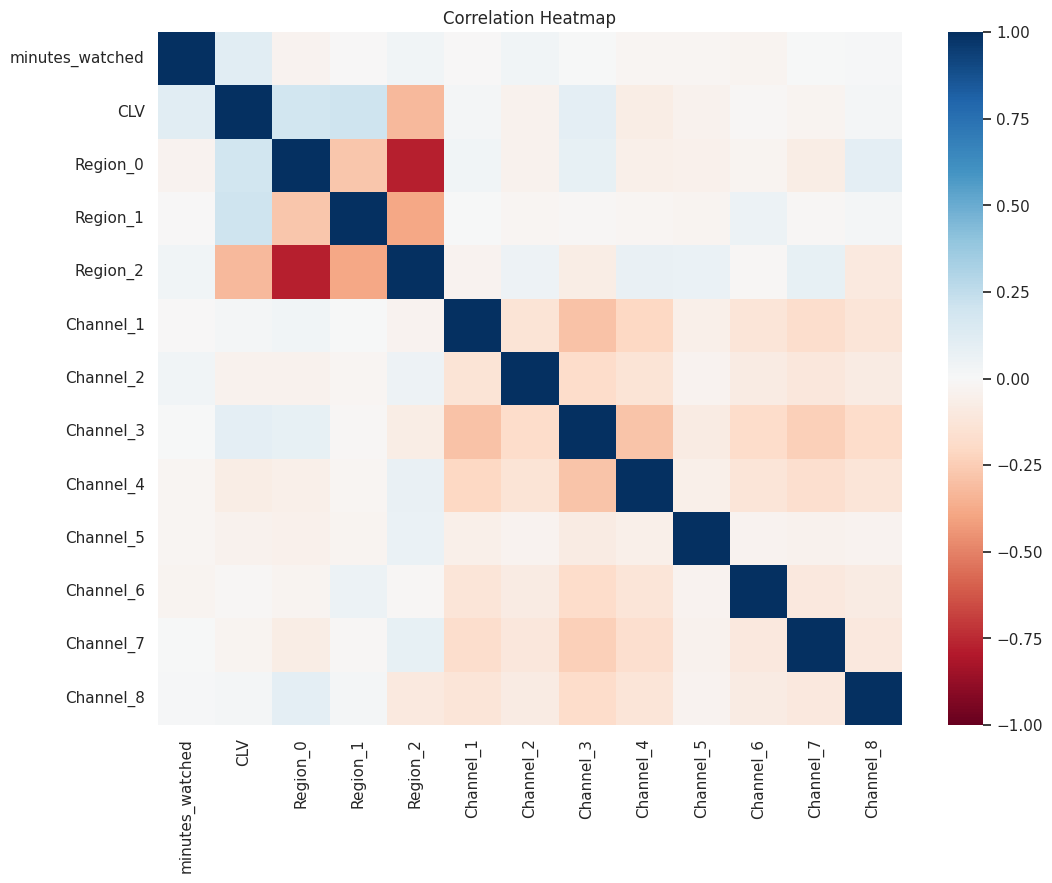

In [ ]:
corr = df.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()




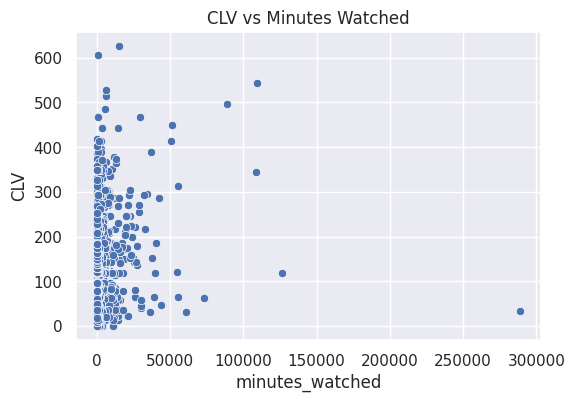

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="minutes_watched", y="CLV")
plt.title("CLV vs Minutes Watched")
plt.show()

## **Standardization → Hierarchical → K-means Elbow → Choose K**

In [ ]:
features = [col for col in df.columns if col not in ["student_id"]]  # adjust if you have id column
X = df[features]


In [ ]:
X = df[["minutes_watched", "CLV"]]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


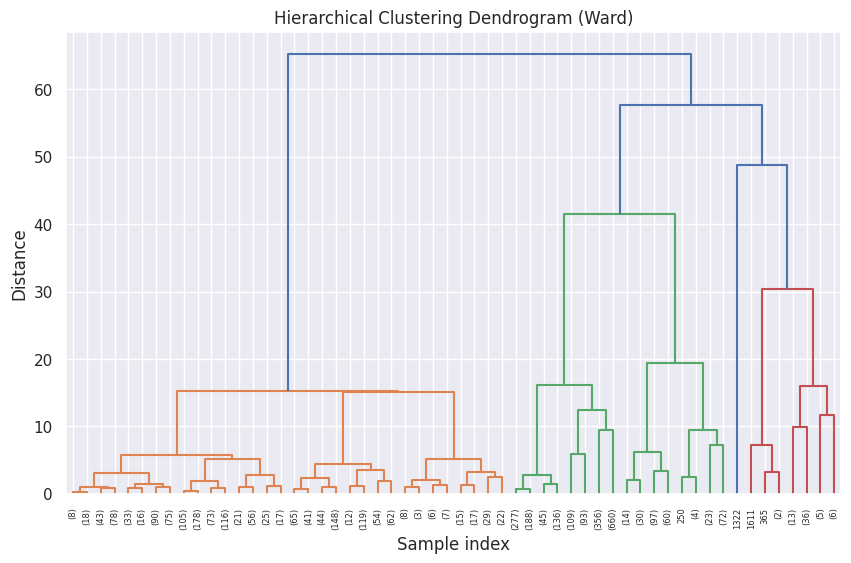

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
Z = linkage(X_scaled, method="ward")
dendrogram(Z, truncate_mode="level", p=5)   # only top levels to keep it readable
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


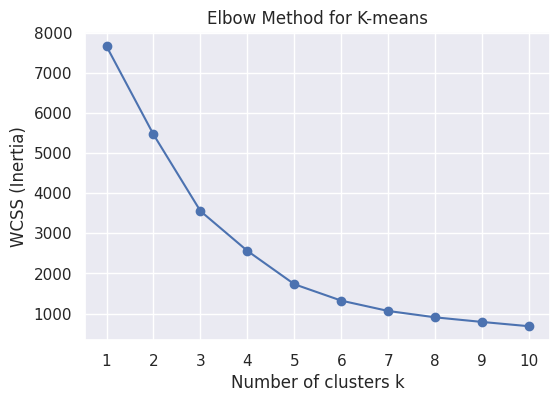

In [ ]:
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)   # sum of squared distances

plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, marker="o")
plt.title("Elbow Method for K-means")
plt.xlabel("Number of clusters k")
plt.ylabel("WCSS (Inertia)")
plt.xticks(K_range)
plt.show()


In [ ]:
best_k = 4   # replace with your chosen number


In [ ]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels


In [ ]:
df.groupby("cluster")[["minutes_watched", "CLV"]].mean()


,minutes_watched,CLV
cluster,,
0,1103.211089,147.487126
1,132411.166667,266.546667
2,1587.673065,56.575715
3,7362.672065,287.268016


# **Final K-means → Cluster Summary Table**

In [ ]:
# Example: if dendrogram suggests 4 clusters
best_k = 4   # CHANGE THIS to your number from dendrogram

from sklearn.cluster import KMeans
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels


In [ ]:
cluster_summary = df.groupby("cluster").agg({
    "minutes_watched": ["count", "mean", "std"],    # always exists
    "CLV": ["mean", "std"]                          # always exists
}).round(2)

cluster_summary.columns = ["Size", "Minutes_Mean", "Minutes_Std",
                          "CLV_Mean", "CLV_Std"]
cluster_summary["Proportion"] = (cluster_summary["Size"] / len(df) * 100).round(1)

print(cluster_summary)


         Size  Minutes_Mean  Minutes_Std  CLV_Mean  CLV_Std  Proportion
cluster                                                                
0        1966       1103.21      1993.98    147.49    27.41        51.3
1           6     132411.17     78614.07    266.55   224.74         0.2
2        1615       1587.67      3612.52     56.58    22.84        42.1
3         247       7362.67     11700.93    287.27    76.88         6.4


In [ ]:
print("All columns now:", df.columns.tolist())


All columns now: ['minutes_watched', 'CLV', 'Region_0', 'Region_1', 'Region_2', 'Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8', 'cluster']


In [ ]:
df.groupby("cluster")[["Region_0", "Region_1", "Region_2", "Channel_1", "Channel_2", "Channel_3"]].mean()



,Region_0,Region_1,Region_2,Channel_1,Channel_2,Channel_3
cluster,,,,,,
0,0.494914,0.159715,0.345371,0.165819,0.076806,0.303662
1,0.333333,0.000000,0.666667,0.000000,0.166667,0.333333
2,0.178947,0.054489,0.766563,0.178328,0.087926,0.253251
3,0.412955,0.238866,0.348178,0.230769,0.048583,0.348178


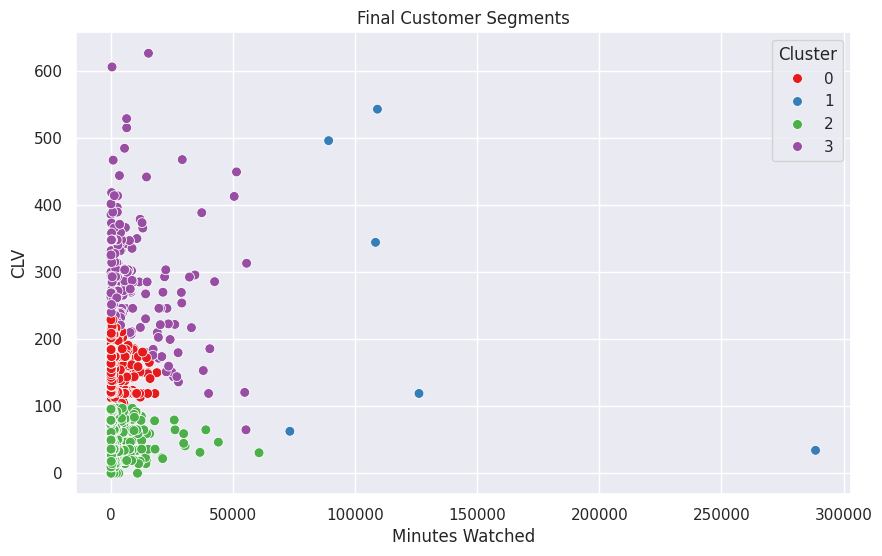

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="minutes_watched", y="CLV", hue="cluster", palette="Set1", s=50)
plt.title("Final Customer Segments")
plt.xlabel("Minutes Watched")
plt.ylabel("CLV")
plt.legend(title="Cluster")
plt.show()


## **Marketing Strategy + Visual**


In [ ]:
# Final channel performance table
channel_summary = pd.DataFrame({
    'Channel': ['Channel_1', 'Channel_2', 'Channel_3'],
    'Top_Clusters_%': ['18%', '5-17%', '30-35%'],
    'Performance': ['Underperforms', 'Weakest', 'Excellent'],
    'Strategy': ['Optimize onboarding', 'Cut 50%', 'Increase 60%']
})
print(channel_summary)


     Channel Top_Clusters_%    Performance             Strategy
0  Channel_1            18%  Underperforms  Optimize onboarding
1  Channel_2          5-17%        Weakest              Cut 50%
2  Channel_3         30-35%      Excellent         Increase 60%


In [ ]:
channel_perf = df.groupby("cluster")[
    ["Region_0", "Region_1", "Region_2", "Channel_1", "Channel_2", "Channel_3"]
].mean() * 100  # convert to %
print(channel_perf.round(1))


         Region_0  Region_1  Region_2  Channel_1  Channel_2  Channel_3
cluster                                                               
0            49.5      16.0      34.5       16.6        7.7       30.4
1            33.3       0.0      66.7        0.0       16.7       33.3
2            17.9       5.4      76.7       17.8        8.8       25.3
3            41.3      23.9      34.8       23.1        4.9       34.8
